In [2]:
import os
import gc
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
DATA_DIRECTORY = ""

In [4]:
train = pd.read_csv(os.path.join(DATA_DIRECTORY, 'train.csv'))
labels = pd.read_csv(os.path.join(DATA_DIRECTORY, 'labels.csv'))

In [5]:
train_ids = train['SK_ID_CURR']
train.drop('SK_ID_CURR', axis=1, inplace=True)
labels = labels.to_numpy()

In [6]:
imputer = SimpleImputer(strategy = 'median')
imputer.fit(train)
train = imputer.transform(train)

In [7]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train)
train = scaler.transform(train)

In [8]:
def model(features, test_features, labels, test_ids, n_folds = 5):
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 8888)
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    ratio = (labels == 0).sum()/ (labels == 1).sum()
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = XGBClassifier(
                  n_estimators=5000,
                  learning_rate=0.01,
                  max_depth=11,
                  objective='binary:logistic', 
                  gamma=0.098, 
                  subsample=0.708,
                  reg_alpha=3.564, 
                  reg_lambda=4.930,
                  random_state=8888,
                  seed=88888,
                  scale_pos_weight=ratio,
                  colsample_bytree= 0.613,
                  min_child_weight= 6,
                  tree_method='gpu_hist',
                  predictor='gpu_predictor'
                  )
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(train_features, train_labels), (valid_features, valid_labels)],
                  early_stopping_rounds = 2500, verbose = 1000)
        
        # Make predictions
        test_predictions += model.predict_proba(test_features)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features)[:, 1]
        
        evals_result = model.evals_result()
        valid_score = max(evals_result['validation_1']['auc'])
        train_score = max(evals_result['validation_0']['auc'])
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, metrics

In [9]:
submission, metrics = model(train, train, labels, train_ids)

Training Data Shape:  (307506, 649)
Testing Data Shape:  (307506, 649)


C:\Users\sakib\anaconda3\envs\CSE499\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\sakib\anaconda3\envs\CSE499\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-auc:0.79603	validation_1-auc:0.69395
[1000]	validation_0-auc:0.99274	validation_1-auc:0.79005
[2000]	validation_0-auc:0.99952	validation_1-auc:0.78887
[3000]	validation_0-auc:0.99997	validation_1-auc:0.78836
[3358]	validation_0-auc:0.99999	validation_1-auc:0.78850
[0]	validation_0-auc:0.79744	validation_1-auc:0.68108
[1000]	validation_0-auc:0.99308	validation_1-auc:0.78418
[2000]	validation_0-auc:0.99957	validation_1-auc:0.78365
[3000]	validation_0-auc:0.99997	validation_1-auc:0.78333
[3651]	validation_0-auc:0.99999	validation_1-auc:0.78344
[0]	validation_0-auc:0.79517	validation_1-auc:0.68705
[1000]	validation_0-auc:0.99313	validation_1-auc:0.78805
[2000]	validation_0-auc:0.99960	validation_1-auc:0.78692
[3000]	validation_0-auc:0.99998	validation_1-auc:0.78678
[3581]	validation_0-auc:1.00000	validation_1-auc:0.78689
[0]	validation_0-auc:0.79514	validation_1-auc:0.68986
[1000]	validation_0-auc:0.99341	validation_1-auc:0.78994
[2000]	validation_0-auc:0.99960	validation_

In [10]:
print('XGBoost metrics')
print(metrics)

XGBoost metrics
      fold     train     valid
0        0  0.999988  0.790278
1        1  0.999993  0.784309
2        2  0.999996  0.788305
3        3  0.999987  0.790216
4        4  0.999992  0.782807
5  overall  0.999991  0.786360


In [11]:
submission.to_csv('xgboost.csv', index = False)

In [16]:
pred = submission['TARGET'].to_numpy()

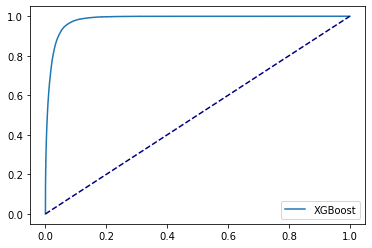

In [32]:
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(labels[:,0],  pred)
auc = roc_auc_score(labels[:,0], pred)
plt.plot(fpr,tpr,label="XGBoost")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  
plt.legend(loc=4)
plt.show()